In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
labels_per_class = 'full' # full

### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [8]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [9]:
dims = (28,28,1)
n_components= 2

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Test model with just UMAP

In [11]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [12]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [13]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [14]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [15]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 60000])
batch_size

50000

### initialize embedding

In [16]:
from umap.spectral import spectral_layout
from sklearn.utils import check_random_state
random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}


def init_embedding_from_graph(
    _raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"
):
    """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
    if isinstance(init, str) and init == "random":
        embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], n_components)
        ).astype(np.float32)
    elif isinstance(init, str) and init == "spectral":
        # We add a little noise to avoid local minima for optimization to come

        initialisation = spectral_layout(
            _raw_data,
            graph,
            n_components,
            random_state,
            metric=metric,
            metric_kwds=_metric_kwds,
        )
        expansion = 10.0 / np.abs(initialisation).max()
        embedding = (initialisation * expansion).astype(
            np.float32
        ) + random_state.normal(
            scale=0.0001, size=[graph.shape[0], n_components]
        ).astype(
            np.float32
        )

    else:
        init_data = np.array(init)
        if len(init_data.shape) == 2:
            if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                tree = KDTree(init_data)
                dist, ind = tree.query(init_data, k=2)
                nndist = np.mean(dist[:, 1])
                embedding = init_data + random_state.normal(
                    scale=0.001 * nndist, size=init_data.shape
                ).astype(np.float32)
            else:
                embedding = init_data

    return embedding

In [17]:
init_embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

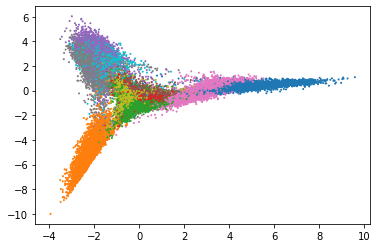

In [18]:
plt.scatter(init_embedding[:,0], init_embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

In [19]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 100
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.034

In [20]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 100
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.034

In [21]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.001
decay_steps = 150

decay_rate = 0.97
learning_rate_rn = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate, decay_steps, decay_rate,
)
opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# 0.33

In [22]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.001
decay_steps = 250

decay_rate = 0.97
learning_rate_rn = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate, decay_steps, decay_rate,
)
opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# 0.33

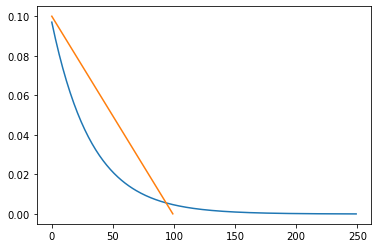

In [23]:
i_list = []
learning_rate = starter_learning_rate

for i in range(decay_steps):
    learning_rate *= decay_rate
    i_list.append(learning_rate)
plt.plot(i_list)
plt.plot(np.linspace(0.1, 0.0001, 100))

In [24]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.031

In [25]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])


decay_steps = 150
opt = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
# ~0.033

In [26]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])


decay_steps = 150
opt = tf.keras.optimizers.Nadam(0.1)
# ~0.035

In [27]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])


decay_steps = 150
opt = tf.keras.optimizers.SGD(learning_rate = 0.01)
# ~0.038

In [28]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.001
decay_steps = 150
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)#, momentum = 0.9)
# 

In [29]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.031

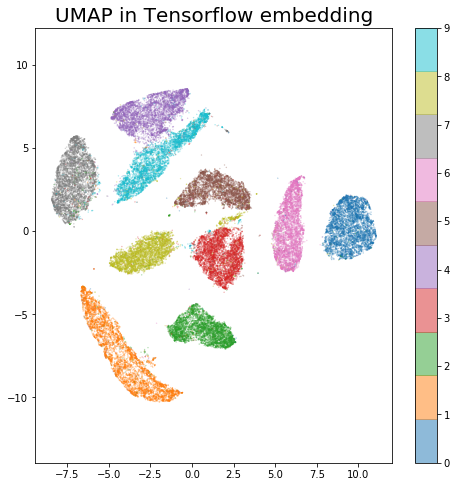

In [30]:
t = tqdm(range(decay_steps))
for batch_n in t:
    with tf.GradientTape() as tape:
        
        embedding_to = tf.gather(embedding, head)
        embedding_from = tf.gather(embedding, tail)
        
        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )
        
        # distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )
        
        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
        
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        ce_loss = ce_loss * weight_tile
        loss = ce_loss
        
    grads = tape.gradient(loss, training_variables)
    grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
    opt.apply_gradients(zip(grads, training_variables))
    
    t.set_description("loss {}".format(str(round(np.mean(loss.numpy()),3))))

    
z = embedding.numpy()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### use layer rather than variable

In [31]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.031

In [32]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [33]:
training_variables = encoder.trainable_variables

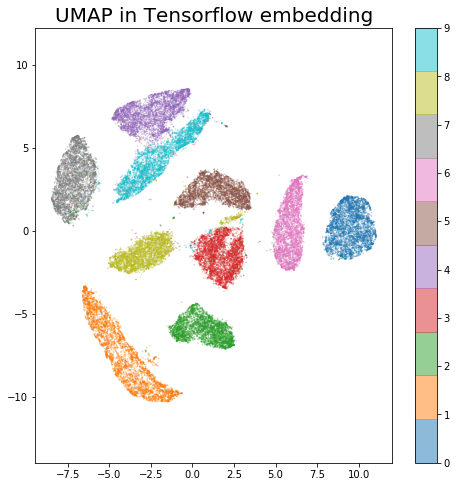

In [34]:
t = tqdm(range(decay_steps))
for batch_n in t:
    with tf.GradientTape() as tape:
        
        #embedding_to = tf.gather(embedding, head)
        #embedding_from = tf.gather(embedding, tail)
        embedding_to = encoder(head)[:,-1,:]
        embedding_from = encoder(tail)[:,-1,:]
        
        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )
        
        # distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )
        
        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
        
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        ce_loss = ce_loss * weight_tile
        loss = ce_loss
        
    grads = tape.gradient(loss, training_variables)
    grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
    opt.apply_gradients(zip(grads, training_variables))
    
    t.set_description("loss {}".format(str(round(np.mean(loss.numpy()),3))))

    
z = encoder.weights[0].numpy()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### make embed data function

In [44]:
embedding = tf.Variable(init_embedding)
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.031

n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

training_variables = encoder.trainable_variables

250/250 [==============================] - 36s 143ms/step


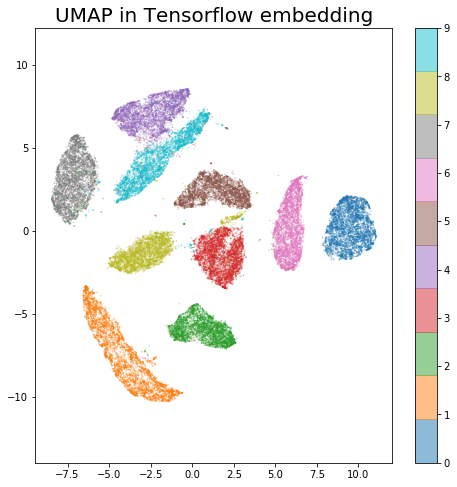

In [47]:
progbar = tf.keras.utils.Progbar(decay_steps)
for batch_n in range(decay_steps):
    with tf.GradientTape() as tape:
        
        embedding_to = encoder(head)[:,-1,:]
        embedding_from = encoder(tail)[:,-1,:]
        
        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )
        
        # distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )
        
        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
        
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        ce_loss = ce_loss * weight_tile
        loss = ce_loss
        
    grads = tape.gradient(loss, training_variables)
    grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
    opt.apply_gradients(zip(grads, training_variables))
    
    progbar.add(1)



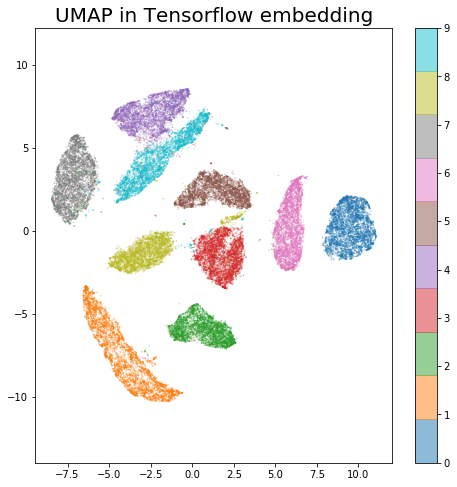

In [48]:
z = encoder.weights[0].numpy()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### try 2

In [109]:
edge_weights = tf.constant(weight)
negative_sample_rate = 5
repulsion_strength = 1
batch_size = len(head)
training_variables = [embedding]
alpha = tf.constant(1.0)
weight_tile = tf.tile(edge_weights, [negative_sample_rate+1])

#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
# ~0.031

n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

training_variables = encoder.trainable_variables

In [110]:
@tf.function
def embed_data(opt, decay_steps, encoder, head, tail, weight_tile, batch_size, repulsion_strength, negative_sample_rate):
    
    training_variables = encoder.trainable_variables
    
    progbar = tf.keras.utils.Progbar(decay_steps)
    for batch in tf.range(decay_steps):
        with tf.GradientTape() as tape:

            embedding_to = encoder(head)[:,-1,:]
            embedding_from = encoder(tail)[:,-1,:]

            # get negative samples
            embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
            repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
            embedding_neg_from = tf.gather(
                repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
            )

            # distances between samples (and negative samples)
            distance_embedding = tf.concat(
                [
                    tf.norm(embedding_to - embedding_from, axis=1),
                    tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
                ],
                axis=0,
            )

            # convert probabilities to distances
            probabilities_distance = convert_distance_to_probability(
                distance_embedding, _a, _b
            )

            # set true probabilities based on negative sampling
            probabilities_graph = tf.concat(
                [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
                axis=0,
            )

            # compute cross entropy
            (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
                probabilities_graph,
                probabilities_distance,
                repulsion_strength=repulsion_strength,
            )
            ce_loss = ce_loss * weight_tile
            loss = ce_loss
        
        grads = tape.gradient(loss, training_variables)
        grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
        opt.apply_gradients(zip(grads, training_variables))

        progbar.add(1)
    
    return tf.reduce_mean(loss)

In [111]:
embed_data(opt, decay_steps, encoder, head, tail, weight_tile, batch_size, repulsion_strength, negative_sample_rate)
print(loss)

250/250 [==============================] - 34s 135ms/step
tf.Tensor(0.03146656, shape=(), dtype=float32)


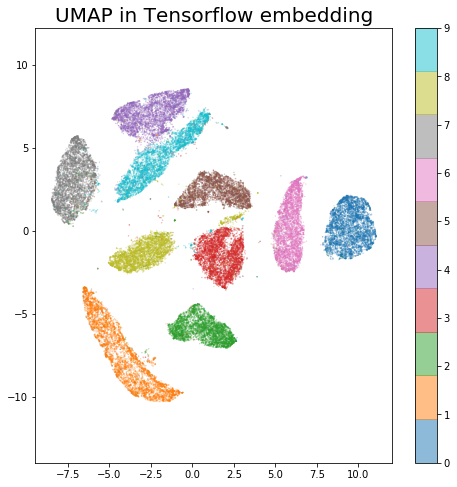

In [113]:
z = encoder.weights[0].numpy()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### make into a keras function...

- custom training loop
- input is (nothing, or head/tail)
- 

In [114]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        if True:
            (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
                probabilities_graph,
                probabilities_distance,
                repulsion_strength=repulsion_strength,
            )
        else:
            ce_loss = tf.keras.losses.binary_crossentropy(probabilities_graph, probabilities_distance)
        #ce_loss = ce_loss * alpha
        #return tf.reduce_mean(ce_loss)
        return ce_loss

    return loss

In [115]:
def make_gen_callable(head, tail, edge_weights):
    def edge_generator():
        while True:
            yield (tf.expand_dims(head,-1), tf.expand_dims(tail,-1), edge_weights), [0]

    return edge_generator

In [116]:
edge_ds = tf.data.Dataset.from_generator( make_gen_callable(head, tail, edge_weights), ((tf.int32, tf.int32, tf.float32), tf.int32))

In [117]:
for (hd, tl, ew), _ in tqdm(edge_ds):
    break

In [118]:
hd.shape

TensorShape([1029582, 1])

In [119]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [120]:
batch_head = tf.keras.Input(shape=(1), dtype=tf.int32, name = "head")
batch_tail = tf.keras.Input(shape=(1), dtype=tf.int32, name = "tail")
batch_weights = tf.keras.Input(shape=(1), dtype=tf.float32, name = "weights")
batch_head, batch_tail

(<tf.Tensor 'head_1:0' shape=(None, 1) dtype=int32>,
 <tf.Tensor 'tail_1:0' shape=(None, 1) dtype=int32>)

In [121]:
embedding_to = encoder(batch_head)[:,-1,:]
embedding_from = encoder(batch_tail)[:,-1,:]
embedding_to, embedding_from

(<tf.Tensor 'strided_slice_2:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'strided_slice_3:0' shape=(None, 2) dtype=float32>)

In [122]:
embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 4) dtype=float32>

In [123]:
model = tf.keras.Model(
    inputs=[batch_head, batch_tail],
    outputs=[embedding_to_from],
)

In [124]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(50),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b),
)

In [125]:
history = model.fit(
    edge_ds,
    epochs=5,
    max_queue_size = 5,
)

Epoch 1/5
    138/Unknown - 23s 164ms/step - loss: 0.2806

KeyboardInterrupt: 

In [126]:
z = encoder.weights[0].numpy()

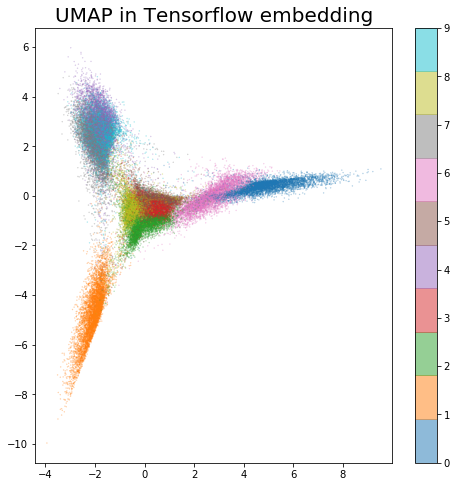

In [127]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

#### try 2

- custom training loop
- input is (nothing, or head/tail)
- 

In [240]:
def make_gen_callable(head, tail, edge_weights):
    def edge_generator():
        while True:
            yield (tf.expand_dims(head,-1), tf.expand_dims(tail,-1), edge_weights), [0]

    return edge_generator

In [241]:
edge_ds = tf.data.Dataset.from_generator( make_gen_callable(head, tail, edge_weights), ((tf.int32, tf.int32, tf.float32), tf.int32))

In [242]:
loss_fn = umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0)

In [243]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            print( 'y', y, 'y_pred', y_pred)
            loss = loss_fn(y, y_pred)

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            gradients = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in gradients] 

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [244]:
for (hd, tl, ew), _ in tqdm(edge_ds):
    break

In [261]:
hd, tl, ew

(<tf.Tensor: shape=(1029582, 1), dtype=int32, numpy=
 array([[ 1482],
        [ 8728],
        [10536],
        ...,
        [33072],
        [34150],
        [44176]], dtype=int32)>,
 <tf.Tensor: shape=(1029582, 1), dtype=int32, numpy=
 array([[    0],
        [    0],
        [    0],
        ...,
        [49999],
        [49999],
        [49999]], dtype=int32)>,
 <tf.Tensor: shape=(1029582,), dtype=float32, numpy=
 array([0.08066241, 0.4961104 , 0.04827981, ..., 0.47979698, 0.5484277 ,
        0.21530996], dtype=float32)>)

In [245]:
hd.shape

TensorShape([1029582, 1])

In [246]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [247]:
batch_head = tf.keras.Input(shape=(1), dtype=tf.int32, name = "head")
batch_tail = tf.keras.Input(shape=(1), dtype=tf.int32, name = "tail")
batch_weights = tf.keras.Input(shape=(1), dtype=tf.float32, name = "weights")
batch_head, batch_tail

(<tf.Tensor 'head_11:0' shape=(None, 1) dtype=int32>,
 <tf.Tensor 'tail_11:0' shape=(None, 1) dtype=int32>)

In [248]:
embedding_to = encoder(batch_head)[:,-1,:]
embedding_from = encoder(batch_tail)[:,-1,:]
embedding_to, embedding_from

(<tf.Tensor 'strided_slice_22:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'strided_slice_23:0' shape=(None, 2) dtype=float32>)

In [249]:
embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from

<tf.Tensor 'concatenate_11/concat:0' shape=(None, 4) dtype=float32>

In [250]:
model = CustomModel(
    inputs=[batch_head, batch_tail, batch_weights],
    outputs=[embedding_to_from],
)

In [251]:
#opt = tf.keras.optimizers.Adadelta(50)
starter_learning_rate = 0.1
end_learning_rate = 0.00001
decay_steps = 250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

#opt = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)#, momentum = 0.9)
opt = tf.keras.optimizers.Adadelta(50)

In [252]:
model.compile(
    optimizer=opt,
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b),
)

In [256]:
history = model.fit(
    edge_ds,
    epochs=5,
    max_queue_size = 5,
)

Epoch 1/5
    634/Unknown - 93s 147ms/step - loss: 0.1160

KeyboardInterrupt: 

In [259]:
z = encoder.weights[0].numpy()

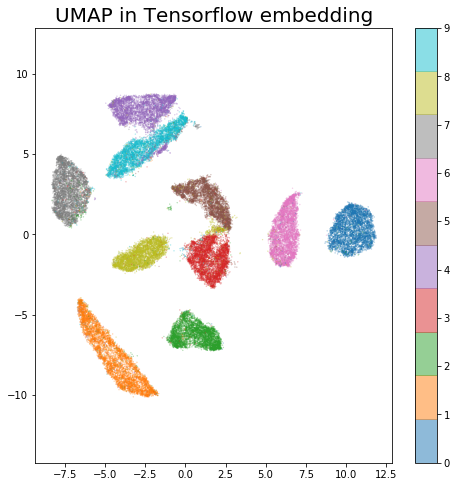

In [260]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [ ]:
###